## BACKLOG

- Dividing hashtags into individual words

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
# import geopandas as gp

import nltk
nltk.download('vader_lexicon')
nltk.download('stopwords')

from nltk.stem.porter import *
stemmer = PorterStemmer()
from nltk.sentiment import SentimentIntensityAnalyzer
sia = SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/shrutikorada/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/shrutikorada/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
tweets = pd.read_csv('Tweets.csv')

## EDA

In [3]:
tweets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14640 entries, 0 to 14639
Data columns (total 15 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   tweet_id                      14640 non-null  int64  
 1   airline_sentiment             14640 non-null  object 
 2   airline_sentiment_confidence  14640 non-null  float64
 3   negativereason                9178 non-null   object 
 4   negativereason_confidence     10522 non-null  float64
 5   airline                       14640 non-null  object 
 6   airline_sentiment_gold        40 non-null     object 
 7   name                          14640 non-null  object 
 8   negativereason_gold           32 non-null     object 
 9   retweet_count                 14640 non-null  int64  
 10  text                          14640 non-null  object 
 11  tweet_coord                   1019 non-null   object 
 12  tweet_created                 14640 non-null  object 
 13  t

<AxesSubplot:>

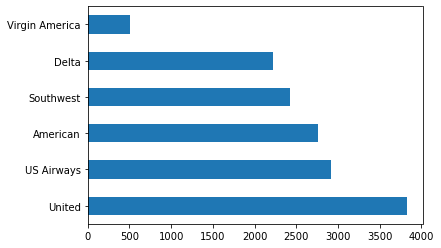

In [4]:
# mentions by airline
tweets.airline.value_counts().plot(kind='barh')

<AxesSubplot:xlabel='negativereason', ylabel='airline'>

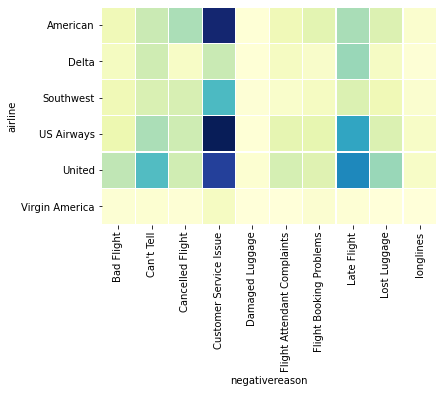

In [5]:
# heatmap by airline and reason
sns.heatmap(pd.crosstab([tweets.airline], [tweets.negativereason]),
            cmap="YlGnBu", annot=False, cbar=False, linewidths=.2)

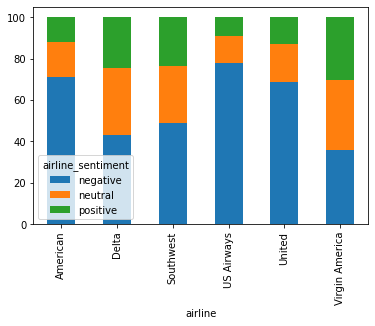

In [6]:
# sentiment stacked bar per airline
x = pd.crosstab(tweets.airline, tweets.airline_sentiment).apply(lambda x: x / x.sum() * 100, axis=1).plot(kind='bar',stacked=True)

American, US Airways, and United have majority negative sentiment, while Virgin, Delta and Southwest skew positive.

Text(0, 0.5, 'Negative Reasons')

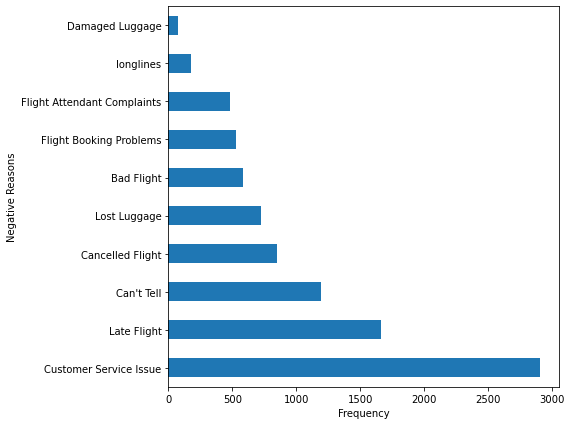

In [19]:
# tweet frequency by negative reason
tweets.negativereason.value_counts().plot(kind='barh',figsize=(7,7))
plt.xlabel('Frequency')
plt.ylabel('Negative Reasons')

In [21]:
# location summary --> create map (geopandas)
tweets.tweet_location.value_counts()

Boston, MA                       157
New York, NY                     156
Washington, DC                   150
New York                         127
USA                              126
                                ... 
fairfield county, connecticut      1
Jupiter                            1
Loveland, Ohio                     1
instagram:Torrinichelle            1
Redmond WA                         1
Name: tweet_location, Length: 3081, dtype: int64

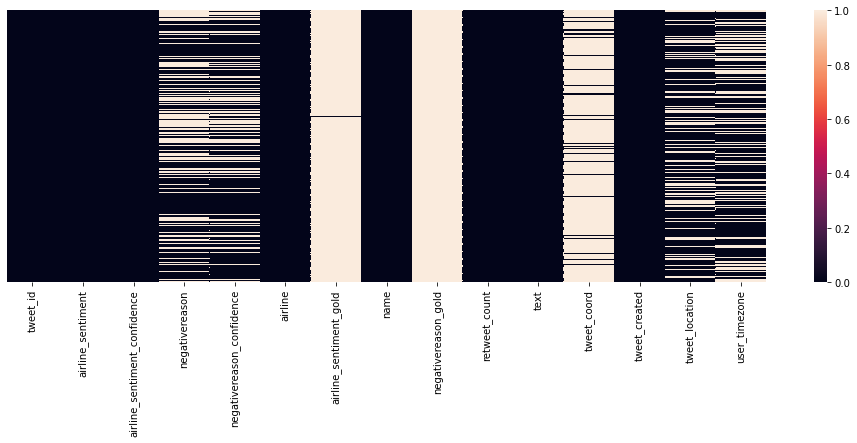

In [8]:
# missing data
plt.figure(figsize=(17, 5))
sns.heatmap(tweets.isnull(), cbar=True, yticklabels=False)
plt.show()

## Text pre-processing

In [9]:
# function to remove @user
def remove_pattern(input_txt, pattern):
    r = re.findall(pattern, input_txt)
    for i in r:
        input_txt = re.sub(i,'',input_txt)
    return input_txt

In [10]:
# additional cleaning
tweets['Tweet'] = np.vectorize(remove_pattern)(tweets['text'], '@[\w]*') # create new column with removed @user
tweets['Tweet'] = tweets['Tweet'].apply(lambda x: re.split('http:\/\/.*', str(x))[0]) # remove urls
tweets['Tweet'] = tweets['Tweet'].str.replace('[^a-zA-Z#]+',' ') # remove special characters, numbers, punctuations

In [11]:
# create new variable tokenized tweet 
tokenized_tweet = tweets['Tweet'].apply(lambda x: x.split())

# remove stopwords
stopwords = nltk.corpus.stopwords.words("english")
tokenized_tweet = [w for w in tokenized_tweet if w not in stopwords]

In [12]:
# join tokens into one sentence
for i in range(len(tokenized_tweet)):
    tokenized_tweet[i] = ' '.join(tokenized_tweet[i])
    
# change df['Tweet'] to tokenized_tweet
tweets['Tweet']  = tokenized_tweet

In [13]:
# tweets after cleaning
tweets['Tweet']

0                                                What said
1        plus you ve added commercials to the experienc...
2        I didn t today Must mean I need to take anothe...
3        it s really aggressive to blast obnoxious ente...
4                 and it s a really big bad thing about it
                               ...                        
14635    thank you we got on a different flight to Chicago
14636    leaving over minutes Late Flight No warnings o...
14637        Please bring American Airlines to #BlackBerry
14638    you have my money you change my flight and don...
14639    we have ppl so we need know how many seats are...
Name: Tweet, Length: 14640, dtype: object

## Deriving sentiment

In [14]:
# what the output of sentiment scoring looks like
sia.polarity_scores("it's really aggressive to blast obnoxious entertainment in your guests' faces &amp; they have little recourse")

{'neg': 0.236, 'neu': 0.628, 'pos': 0.135, 'compound': -0.2716}

In [15]:
# assign sentiment scores
scores = []
for tweet in tweets['Tweet']:
    score = sia.polarity_scores(tweet)
    scores.append(score['compound'])
tweets['sentiment_scores'] = scores
tweets['sentiment_derived'] = ["positive" if w >0 else "negative" if w < 0 else "neutral" for w in tweets['sentiment_scores']]

In [24]:
tweets['sentiment_scores']

0        0.0000
1        0.0000
2        0.0000
3       -0.2716
4       -0.5829
          ...  
14635    0.3612
14636   -0.7906
14637    0.3182
14638    0.3818
14639    0.0772
Name: sentiment_scores, Length: 14640, dtype: float64

In [16]:
# percent match between assigned and derived sentiment
tweets['match'] = (tweets['sentiment_derived']==tweets['airline_sentiment']).astype(int)
tweets[['airline_sentiment','sentiment_derived','match']]
tweets['match'].mean()

0.5368852459016393

About 50% of the derived sentiment scores match the original scores. Additional pre-processing required. Most of the errors are negative or neutral tweets that are misclassified as neutral or positive:

In [17]:
# crosstab of assigned vs derived sentiment
pd.crosstab(tweets.airline_sentiment, tweets.sentiment_derived)

sentiment_derived,negative,neutral,positive
airline_sentiment,,,
negative,4509,1656,3013
neutral,414,1303,1382
positive,98,217,2048
